# L8 exercise

Below is the 'nearly' complete FWI algorithm - only the value of $\alpha$ is missing.

1. Find the range of values of $\alpha$ for which the algorithm shows reasonable convergence. What appears to be roughly the optimal value?
2. Change the source and receiver locations. How do different acquisition geometries affect the results? (Note that you may also need to extend the simulation time for certain geometries).
3. Play around with some other buttons (source and receiver numbers, boundary layer width, space order or the wave-field etc.) to see how these changes impact the quality of the final image.

In [1]:
# This cell contains the various imports we will need

import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver

from devito import configuration
configuration['log-level'] = 'WARNING'

### Load a subset of the Marmousi velocity model

We choose our $v_p$ model to have a size of 401x201 (instead of the full 1601x401 contained in the original data file) to save computational cost. We smooth the original/true model $v_p$ and save the smoothed model in `model0` as an initial velocity model for FWI. We also set the model spacing to be `dx=dz=10m`, with origin `x0=z0=0`, and padding boundary `nbl=10`. The plots below shows true & smooth models, and their difference.

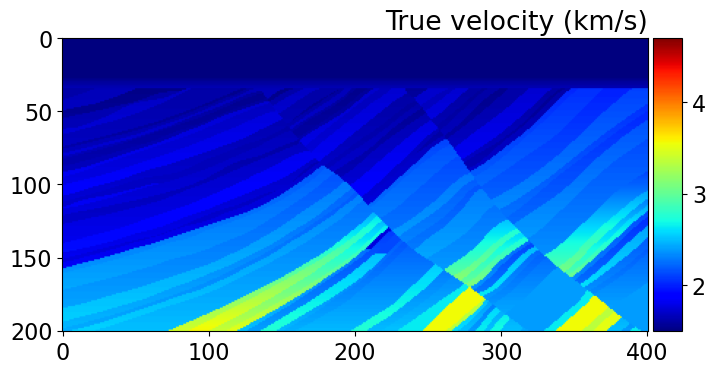

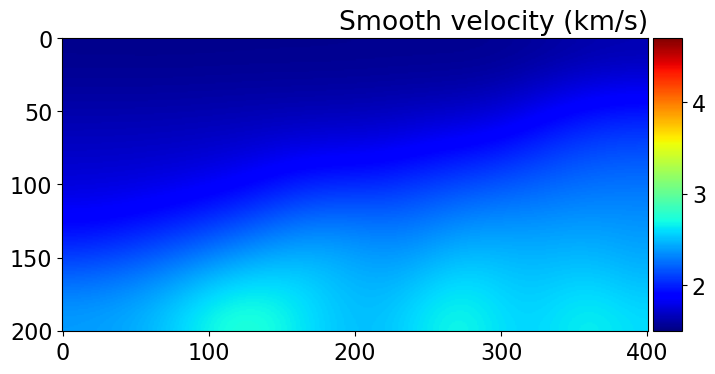

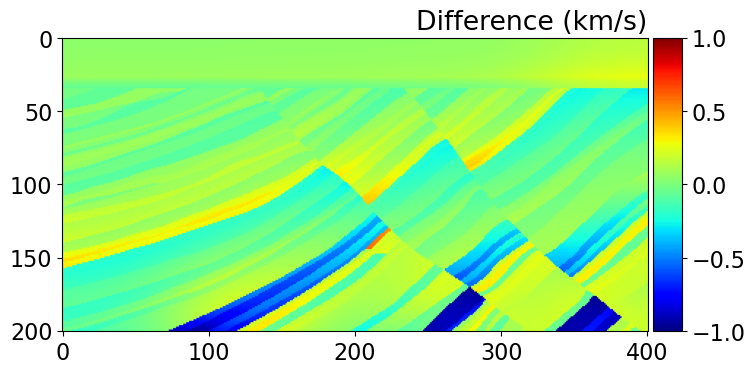

In [2]:
#Load 2D Marmousi velocity model, update the path of 'vp_marmousi_bi' as needed
v = np.fromfile('vp_marmousi_bi', dtype='float32', sep="")

#Velocity model dimension
shape = (1601, 401)
spacing = (10., 10.)
origin = (0., 0.)
nbl = 10
v = v.reshape(shape)

#Cut velocity model size from (1601,401) to (401,201)
v = v[600:-600, :201]

# Gaussian smoothing of the true velocity model
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)

#True Vp model
model = Model(vp=v, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
              shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

#Smooth/Initial Vp model
model0 = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
               shape=v.shape, origin=origin, spacing=spacing, bcs="damp")

#Plot true & smooth Vp models, and their difference
from examples.seismic import plot_image
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Smooth velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Difference (km/s)', loc='right')
plot_image(v_sm-v, vmin=-1.0, vmax=1.0, cmap="jet")

## Set up the acquisition geometry

In part 1, we will use 11 sources and 101 receivers that spread evenly across the whole horizontal dimension of the Vp model, at a depth of 20m. In the plot below, the top figure shows the acquisition geometry (red dot=source, green dot=receiver), overlaid with the True Vp model. The bottom figure shows the Ricker source wavelet used for this demo.

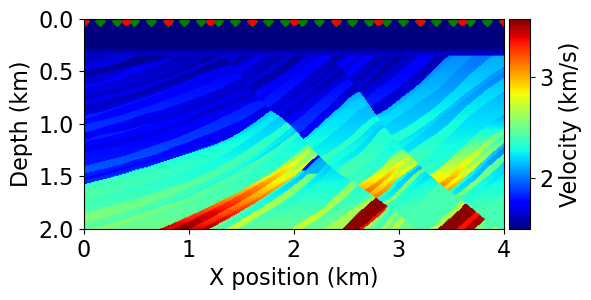

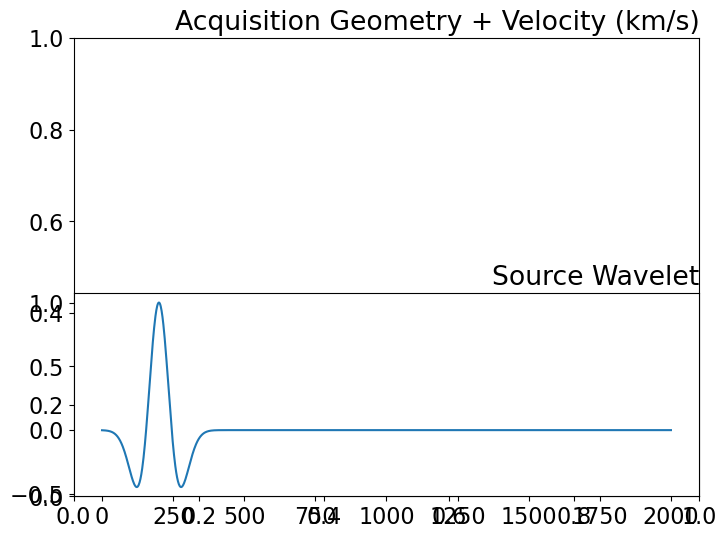

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from examples.seismic import AcquisitionGeometry
from examples.seismic.plotting import plot_velocity

# Set the number of sources and receivers
nsrc = 11   # Number of sources
nrcv = 101  # Number of receivers

# Set 11 source locations
src_loc = np.empty((nsrc, 2), dtype=np.float32)
src_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nsrc)  # x-coordinates of the sources
src_loc[:, 1] = 20.  # y-coordinate of the sources (constant)

# Set 101 receiver locations
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
rcv_loc[:, 0] = np.linspace(0., model.domain_size[0], num=nrcv)  # x-coordinates of the receivers
rcv_loc[:, 1] = 20.  # y-coordinate of the receivers (constant)

# Define the time parameters for the shot records
t0 = 0.     # Start time of the shot records (seconds)
tn = 2000.  # End time of the shot records (milliseconds)
f0 = 0.005  # Peak frequency of the source wavelet (Hz)

# Create acquisition geometry using the specified source and receiver locations
geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

# Plot acquisition geometry overlaid with the true Vp (velocity model), and source wavelet
fig = plt.gcf()
fig.set_size_inches(6, 6)

# Plot the velocity model with source and receiver locations overlaid
plt.subplot(2, 1, 1)
plot_velocity(model, source=src_loc, receiver=rcv_loc[::4])  # Plot every one in four receivers for clarity
plt.title('Acquisition Geometry + Velocity (km/s)', loc='right')

# Plot the source wavelet
plt.subplot(2, 1, 2)
plt.plot(geom_all.src.time_values, geom_all.src.data[:, 0])
plt.title('Source Wavelet', loc='right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Forward model true shot records with the true velocity model

We pick a specific source number and run forward modeling for demonstration. In this case `isrc=3`, but it can be any number between 1 and 11. For this particular source, we run forward modeling twice, one with original/true Vp ("model") and the other with smooth/initial Vp ("model0"). The forward modeling outputs modeled shot data "record" and "record0", respectively. We plot four figures: acquisition geometry with this particular source, shot record from original/ture Vp, shot record from smooth/initial Vp, and their difference. The shot record difference is used to derive FWI gradient.

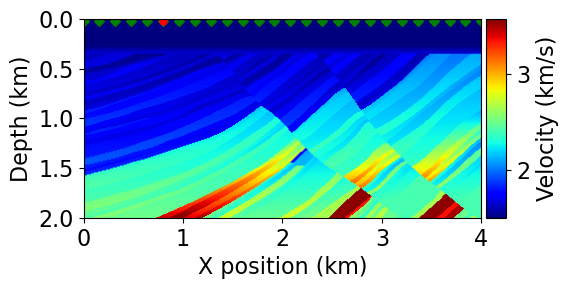

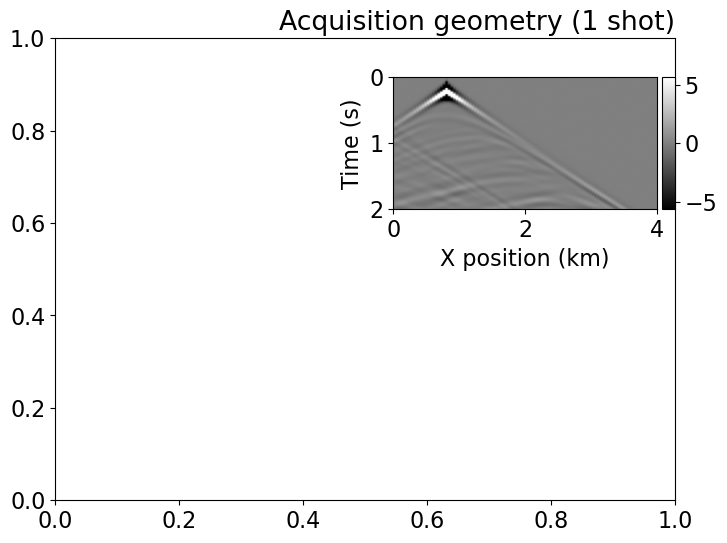

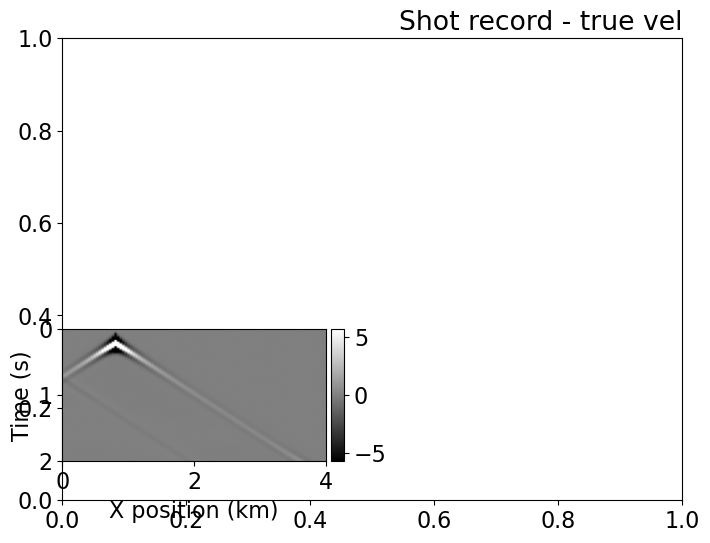

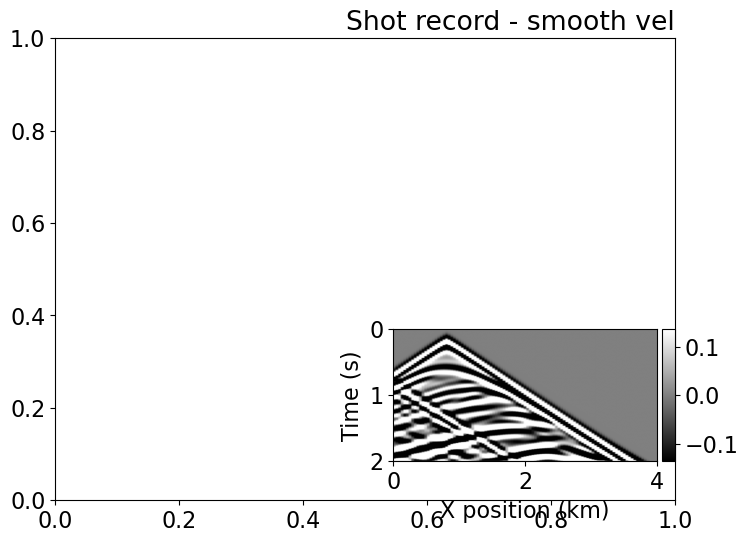

In [4]:
#Pick one source number
isrc = 3
geometry = AcquisitionGeometry(model, rcv_loc, np.copy(src_loc[isrc-1:isrc,:]),
                               t0, tn, f0=f0, src_type='Ricker')
solver = AcousticWaveSolver(model, geometry, space_order=4)

#Define forward modeling of one source
def modeling_1src(vp_in):    
    # Create symbols to hold the data
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    # Generate modeled data from true model
    _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
    # Compute modeled data and full forward wavefield u0 from smooth model
    _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
    return d_obs, d_syn

#Genearte modeled shot data of both true and smooth velocity models
record, record0 = modeling_1src(model0.vp)

#Plot acquisition geometry and modeled shot data
from examples.seismic.plotting import plot_velocity, plot_shotrecord
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.subplot(2,2,1); plot_velocity(model, source=src_loc[isrc-1:isrc,:], receiver=rcv_loc[::4]);
plt.title('Acquisition geometry (1 shot)', loc='right')
plt.subplot(2,2,2); plot_shotrecord(record.data, model, t0, tn)
plt.title('Shot record - true vel', loc='right')
plt.subplot(2,2,3); plot_shotrecord(record0.data, model, t0, tn)
plt.title('Shot record - smooth vel', loc='right')
plt.subplot(2,2,4); plot_shotrecord(record0.data - record.data, model, t0, tn)

## Run 2D FWI with the modeled true shot records and the initial velocity model

### Define FWI Gradient Operator
To compute a single FWI gradient in our workflow, we again use `solver.forward` to compute the entire forward wavefield `u` and a similar pre-defined operator to compute the adjoint wavefield v. The gradient operator provided by our solver utility also computes the correlation between the two wavefields u and v, allowing us to derive the FWI gradient. Those three steps that derive the FWI gradient for a particular source are listed below. This procedure is applied to multiple sources and summed to obtain a FWI gradient image of the subsurface. 
* Simulate the forward wavefield u with the background velocity model to obtain the modeled data and save u
* Compute the data residual between the modeled data and true data
* Back-propagate the data residual to derive the wavefield v, and correlate v with the saved wavefield u to compute on the fly the FWI gradient at each time step which will be summed

In [5]:
# This cell contains some functions needed by our FWI algorithm/

# Function to compute the residual between true/observed and modeled/synthetic data
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # Compute the residual via a difference operator for MPI
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual



# Function to create FWI gradient kernel 
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient, data residual and data
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nsrc):
        # Update source location
        geometry.src_positions[0, :] = src_loc[i, :]
        # Generate true data "d_obs" from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        # Compute smooth/modeled data "d_syn" and full forward wavefield "u0"
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        # Compute data "residual" from "d_obs" and "d_syn"
        compute_residual(residual, d_obs, d_syn)
        # Update objective function 
        objective += .5 * norm(residual)**2
        # Derive FWI gradient "grad" 
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    return objective, grad

# Function to perform the gradient decent update (with box constraints)
from sympy import Min, Max
def update_with_box(vp, alpha, direction, vmin=1.5, vmax=4.7):
    """
    Apply gradient update in-place to vp with box constraint
    """
    update = vp + alpha * direction
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [6]:
def line_search_alpha(model_vp, direction, fwi_gradient_fn, rho=0.5, c=1e-4, max_trials=10):
    alpha = 1.0
    print(mmax(direction))
    vp_orig = model_vp.data.copy()
    
    # Compute the original objective function value
    obj_old, _ = fwi_gradient_fn(model_vp)

    # Try reducing alpha until a sufficient decrease is observed
    for trial in range(max_trials):
        print("Running.")
        # Tentative update
        model_vp.data[:] = vp_orig + alpha * direction.data

        # Compute new objective (only)
        obj_new, _ = fwi_gradient_fn(model_vp)

        # Armijo condition
        if obj_new <= obj_old - c * alpha * np.linalg.norm(direction.data)**2:
            return alpha  # Acceptable alpha found

        alpha *= rho  # Reduce alpha and retry

    # If no good step size found, revert model and return very small step
    model_vp.data[:] = vp_orig
    print("Line search failed, using fallback alpha.")
    return 1e-6

Below we define our FWI iteration loop. The value of alpha is currently undefined and hence this cell wont currently run!

In [7]:
import time # For timing puposes only
fwi_start = time.time()

# Run FWI with gradient descent
fwi_iterations = 20
objective = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the current FWI objective function and gradient
    objective[i], direction = fwi_gradient(model0.vp)
    
    alpha = 0.05 / mmax(direction)

    # Update the velocity model in-place and enforce min/max value clips
    update_with_box(model0.vp, alpha, direction)
    
    # Log the progress of objective function value
    print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


fwi_end = time.time()
print('Total FWI runtime (min):', (fwi_end-fwi_start)/60.0)
print('FWI runtime (min) per iteration:', (fwi_end-fwi_start)/60.0/float(fwi_iterations))

/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     68443.8   at iteration   1


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     51138.1   at iteration   2


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     37679.7   at iteration   3


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     29909.2   at iteration   4


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     24119.2   at iteration   5


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     21035.4   at iteration   6


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     20650.7   at iteration   7


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     16542.1   at iteration   8


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     14753.3   at iteration   9


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     13418.8   at iteration  10


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     18499.7   at iteration  11


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     10699.8   at iteration  12


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is      9105.5   at iteration  13


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is      8556.1   at iteration  14


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is      7563.1   at iteration  15


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     18067.5   at iteration  16


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is      7703.9   at iteration  17


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is      5757.2   at iteration  18


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Objective value is     12309.9   at iteration  19
Objective value is      4340.2   at iteration  20
Total FWI runtime (min): 4.574708716074626
FWI runtime (min) per iteration: 0.2287354358037313


/var/folders/t8/g6w9mwdd78bg__5k6dqjcp_80000gn/T/ipykernel_5340/4033480878.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Objective value is %11.1f   at iteration %3d' % (objective[i], i+1))


Below are some cells to check the result:

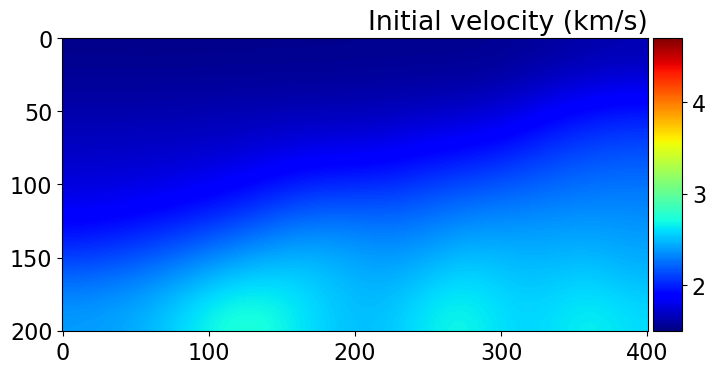

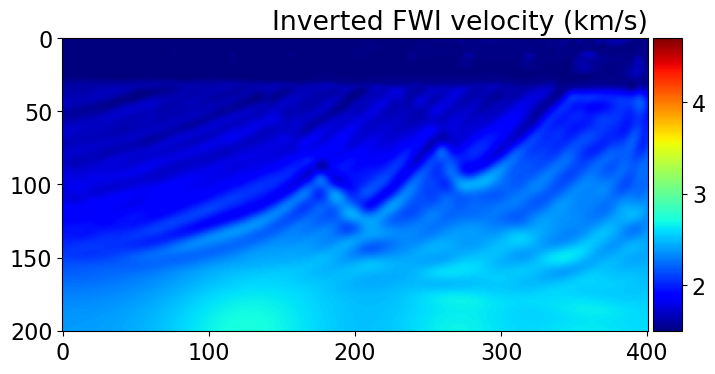

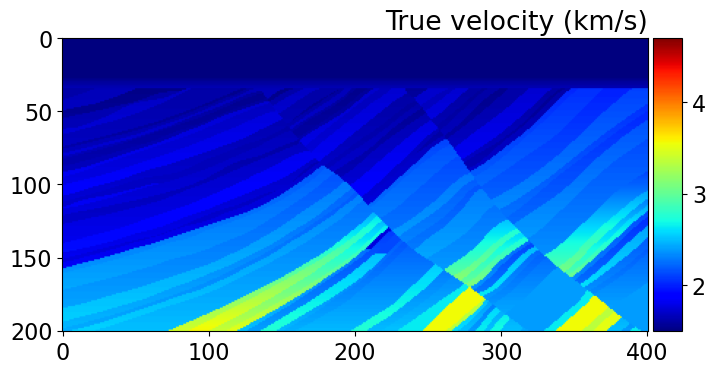

In [8]:
from examples.seismic import plot_image

# Plot initial/smooth velocity model
plt.title('Initial velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")

# Plot inverted velocity model from FWI
plt.title('Inverted FWI velocity (km/s)', loc='right')
plot_image(model0.vp.data[nbl:-nbl, nbl:-nbl], vmin=1.5, vmax=4.7, cmap="jet")

# Plot True velocity model
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")

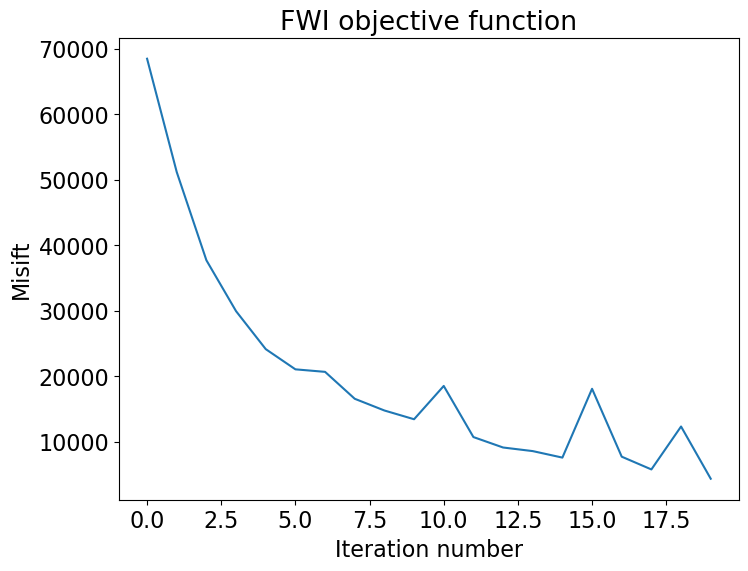

In [9]:
# plot objective function
plt.plot(objective)
plt.xlabel('Iteration number')
plt.ylabel('Misift')
plt.title('FWI objective function')
plt.show()